## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import torch
import torch.nn as nn
import torch.nn.functional as F
# Your plot code here
from IPython.display import clear_output
from random import sample

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab01_Poetry_generation/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2023-06-12 17:32:03--  https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab01_Poetry_generation/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.01s   

2023-06-12 17:32:03 (8.06 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
rows = text.copy()

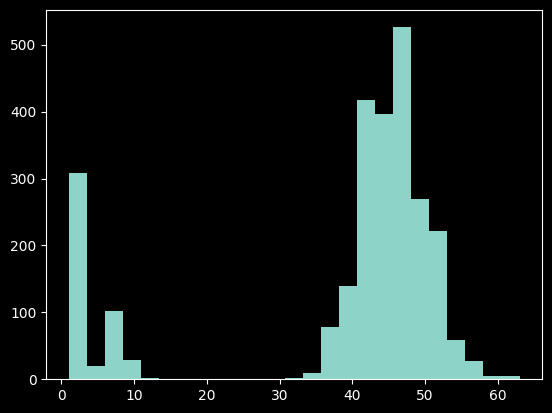

In [ ]:
plt.hist(list(map(len, rows)), bins=25)
plt.show()

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = "".join(text).lower()
# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding="utf-8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = set()
for token in text:
    tokens.add(token)

tokens = sorted(tokens)

In [ ]:
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for index, char in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = {index: char for index, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [ ]:
def to_matrix(rows, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    if not max_len:
        max_len = max(map(len, rows))
    batch = pad*np.ones(shape=(len(rows), max_len), dtype=dtype)
    for i in range(len(batch)):
        idxs = [token_to_idx[char] for char in rows[i].lower()]
        batch[i, :len(idxs)] = idxs
        
    if not batch_first:
        batch = np.transpose(batch)
        
    return batch

In [ ]:
print(*rows[:3])
ex_batch = to_matrix(rows[:3])
print(ex_batch)

  From fairest creatures we desire increase,
   That thereby beauty's rose might never die,
   But as the riper should by time decease,

[[ 1  1 17 29 26 24  1 17 12 20 29 16 30 31  1 14 29 16 12 31 32 29 16 30
   1 34 16  1 15 16 30 20 29 16  1 20 25 14 29 16 12 30 16  6  0  1]
 [ 1  1 31 19 12 31  1 31 19 16 29 16 13 36  1 13 16 12 32 31 36  3 30  1
  29 26 30 16  1 24 20 18 19 31  1 25 16 33 16 29  1 15 20 16  6  0]
 [ 1  1 13 32 31  1 12 30  1 31 19 16  1 29 20 27 16 29  1 30 19 26 32 23
  15  1 13 36  1 31 20 24 16  1 15 16 14 16 12 30 16  6  0  1  1  1]]


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
# Your code here
class VanilaRNN(nn.Module):
    def __init__(self, num_tokens = len(tokens), emb_dim=64, hidden_size=128):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(self.num_tokens, self.emb_dim)
        self.hidden_update = nn.Linear(self.emb_dim+self.hidden_size, self.hidden_size)
        self.hidden2logits = nn.Linear(self.hidden_size, self.num_tokens)
        
    def forward(self, x, h_prev):
        # x = (batch_size), h_prev = (batch_size, hidden_size)
        x_emb = self.embedding(x) # (batch_size, emb_dim)
        x_h = torch.cat((x_emb, h_prev), axis=1) # (batch_size, emb_dim + hidd_dim)
        h_next = torch.tanh(self.hidden_update(x_h))  # (batch_size, hidd_dim)
        
        logits = self.hidden2logits(h_next)  # (batch, num_tokens)
        
        return h_next, F.log_softmax(logits, dim=-1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)
        

In [ ]:
def rnn_loop(vanila_rnn, batch_ix):
    batch_size, max_len = batch_ix.size()
    hidden_state = vanila_rnn.initial_state(batch_size)
    
    logprobs = []
    for x_t in batch_ix.transpose(0, 1):
        hidden_state, logits = vanila_rnn(x_t, hidden_state)
        logprobs.append(logits)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

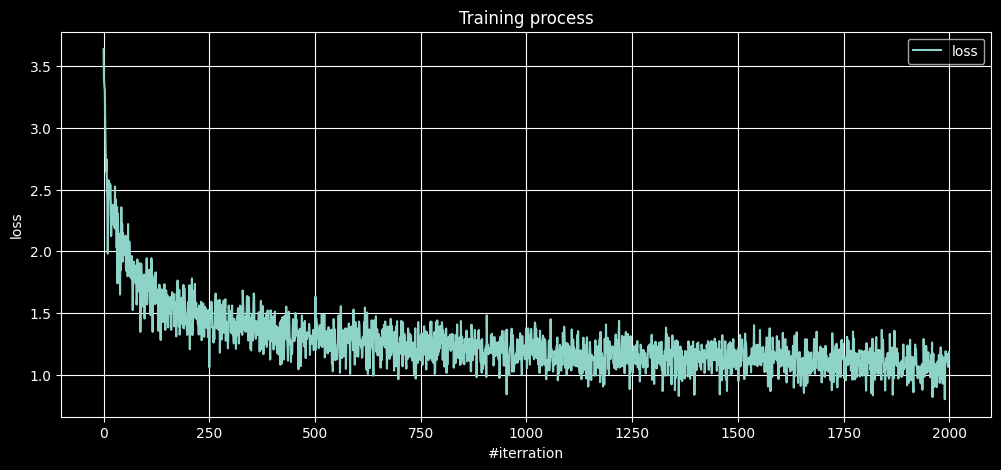

In [ ]:


batch_size = 32
def train_model(model, criterion, optimizer, num_itter=100, plot_every=10, batch_size=batch_size):
    history = []
    for i in range(num_itter):
        batch_ix = to_matrix(sample(rows, 32))
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        logp_seq = rnn_loop(char_rnn, batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                         actual_next_tokens.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        history.append(loss.data.numpy())
        
        if (i+1)%plot_every==0:
            clear_output(True)
            plt.figure(figsize=(12, 5))
            plt.grid()
            plt.plot(history, label='loss')
            plt.legend()
            plt.xlabel("#iterration")
            plt.ylabel("loss")
            plt.title("Training process")
            plt.show()
            
    return history


char_rnn = VanilaRNN()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(char_rnn.parameters())
history = train_model(char_rnn, criterion, optimizer, num_itter=2000, plot_every=100)

In [ ]:
MAX_LENGTH = 55
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase.lower()]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    with torch.no_grad():
        for _ in range(max_length - len(seed_phrase)):
           # print(x_sequence.shape, x_sequence, hid_state.shape)
            hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
            # Be really careful here with the model output
            p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

            # sample next token and push it back into x_sequence
            #print(p_next.shape, len(tokens))
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            #print(x_sequence.shape, next_ix.shape)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

for _ in range(10):
  print(generate_sample(char_rnn, seed_phrase=' '))

    but kind,
                                         
  no forsul's ane of self tell with loving and on yourt
  cxi
                                                 
  where nembere.
                                      
  shath to me agreving race
                           
  as me againtu'd,
                                    
  as it book, but my our praises as that to ad it me pl
  and you are,
                                        
  croves sthis cherest revent
                         
  surild onferus or demong mights to putious divies blo


In [ ]:
MAX_LENGTH = 500
print(generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=0.5))

  with thine of bright, that thou prease knows not but some of the sain with the part contrest thou art sure and thy seem to thy be thine mook beauty along the words, and thee,
                                                                                                                                                                                                                                                                                                                                   


In [ ]:
# An example of generated text.
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' ', temperature=0.5))

  i have that the strain,
                             
    their beauty self all all the twer to mence be thee
  xiv
                                                 
  o    they me,
                                       
  the praise by shall with my sumble glate,
           
    and thee, why with this say thee,
                 
  and of thee the the beauty so the all wear the the ta
  o! he with the sune love with then where of beauty be
    the watter dear of the say that of his preaker whos
  i dear that i am and doth thee well for the teet thou


In [ ]:
# An example of generated text.
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' ', temperature=0.35))

  as thee,
                                            
  that with the this thee to the thy self all the prien
  and that i the stranger state the sweet shall thee is
  the seem that i love the lives thy say,
             
  and the time,
                                       
    and the with to the canst thou be thy shall of the 
  like i to thy proud the words and all the grows thine
  the world so the beauty with that the beauty as thy f
  and thou art and thy see strange thee with the prow,

  the world thou were the to the same the she have the 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
MAX_LENGTH = 55

In [ ]:
class MyRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, token_to_id=token_to_idx, num_layers=1):
        super(self.__class__, self).__init__()
        self.emb_size = emb_size
        self.num_units = rnn_num_units
        self.token_to_id = token_to_id
        self.num_layers = num_layers
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.GRU(emb_size, rnn_num_units, batch_first=True, num_layers=self.num_layers)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq,  final_hidden = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, final_hidden
    
    def generate_text(self, seed_phrase, final_hidden, cell_state, temperature=1.0, max_length=MAX_LENGTH):
        x_sequence = [token_to_idx[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        
        final_hidden, cell_state = torch.zeros(self.num_layers, 1, self.num_units), torch.zeros(self.num_layers, 1, self.num_units)
        with torch.no_grad():
            for _ in range(max_length - len(seed_phrase)):
                _,  final_hidden = self.rnn(model.emb(x_sequence), (final_hidden, cell_state))
                
                next_logits = self.hid_to_logits(final_hidden)
                next_logp = F.log_softmax(next_logits, dim=-1)
                p_next = F.softmax(next_logp / temperature, dim=-1).data.numpy()[0][0]

                # sample next token and push it back into x_sequence
                next_ix = np.random.choice(num_tokens, p=p_next)
                next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
                x_sequence = torch.cat([x_sequence, next_ix], dim=1)
                
        return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])


In [ ]:
batch_ix = to_matrix(rows[:3])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

my_rnn = MyRNN()
next_logp, final_hidden = my_rnn(batch_ix)
next_logp.shape, final_hidden.shape

(torch.Size([3, 46, 38]), torch.Size([1, 3, 64]))

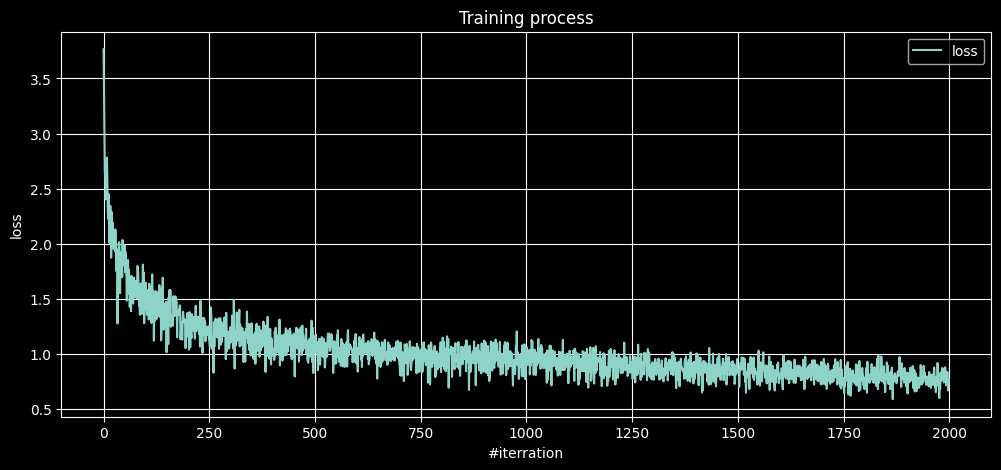

In [ ]:
batch_size = 32
def train_model(model, criterion, optimizer, num_itter=500, plot_every=100, batch_size=batch_size):
    history = []
    for i in range(num_itter):
        batch_ix = to_matrix(sample(rows, batch_size))
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        logp_seq, final_hidden = model(batch_ix)

        # compute loss
        loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                         batch_ix[:, 1:].contiguous().view(-1))
        
        # train with backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        history.append(loss.data.numpy())
        if (i+1)%100==0:        
            clear_output(True)
            plt.figure(figsize=(12, 5))
            plt.grid()
            plt.plot(history,label='loss')
            plt.legend()
            plt.xlabel("#iterration")
            plt.ylabel("loss")
            plt.title("Training process")
            plt.show()
    return final_hidden, cell_state

model = MyRNN(emb_size=128, rnn_num_units=256, num_layers=1)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())
batch_size = 32
final_hidden, cell_state = train_model(model, criterion, optimizer, num_itter=2000, plot_every=100, batch_size=batch_size)

In [ ]:
for _ in range(10):
    print(model.generate_text(seed_phrase=" ", temperature=1.0, max_length=59))

TypeError: ignored

In [ ]:
def generate_text(model, seed_phrase, final_hidden, temperature=1.0, max_length=MAX_LENGTH):
        x_sequence = [token_to_idx[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        #final_hidden, cell_state = torch.zeros(1, 1, model.num_units), torch.zeros(1, 1, model.num_units)
        with torch.no_grad():
            for _ in range(max_length - len(seed_phrase)):
                hid, final_hidden = model.rnn(model.emb(x_sequence), final_hidden)
                #print(hid.shape)
                
                next_logits = model.hid_to_logits(final_hidden)
                next_logp = F.log_softmax(next_logits, dim=-1)
                p_next = F.softmax(next_logp / temperature, dim=-1).data.numpy()[0][0]

                # sample next token and push it back into x_sequence
                next_ix = np.random.choice(num_tokens, p=p_next)
                next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
                x_sequence = torch.cat([x_sequence, next_ix], dim=1)
                
        return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
final_hidden = torch.zeros((1, 256))

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
temps = [0.25, 0.50, 0.75, 1.0, 2.0]
MAX_LENGTH = 60
for i, T in enumerate(temps):
  print(f"Temperature: {T} \n")
  for _ in range(4):
      gen_text = generate_text(model, seed_phrase=" ", final_hidden=final_hidden.unsqueeze(1),  temperature=T, max_length=MAX_LENGTH)
      print(gen_text)

Temperature: 0.25 

   then thou art,
                                          
   then i love thee,
                                       
   then i love thee,
                                       
   then i love thee,
                                       
Temperature: 0.5 

   for this look,
                                          
   or eyes hand,
                                           
    when i do now forth,
                                   
   thou wilt love,
                                         
Temperature: 0.75 

   and walke;
                                              
   or victor gevent;
                                       
   when i joe,
                                             
   and these thee,
                                         
Temperature: 1.0 

   this aborm.
                                             
   maid benits  and chee?
                                  
           for namen confounces,
                           
   'tis

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)